<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Exercise 2: Multiclass logistic regression from scratch </h1>

<hr />
<center>Constructor Academy, 2024</center>



We will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

1. Implement a `predict_proba` function for predicting probabilities for multi class classification via the softmax function. You used the softmax function already during prework when you built a neural network from scratch (acutally logistic regression can be seen as a very simple neural network):
$y = softmax(\mathbf{W} x + b)$

1. build a `predict` function which returns the most probable class given an input $x$

1. build an `accuracy` function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

1. build a `grad` function which computes $\frac{d}{dW} -\log(softmax(Wx + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

1. build a `train` function which uses the `grad` function output to update $\mathbf{W}$ and $b$

In [1]:
%matplotlib inline
#%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm
import random
import sys

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix

In [6]:
plt.style.use("seaborn-v0_8")

## 1. Load the Dataset

We will be using the Digits dataset from sklearn. This dataset is made up of 1797 8x8 images. Each image, like the one shown below, is of a hand-written digit. In order to utilize an 8x8 figure like this, we’d have to first transform it into a feature vector with length 64.

In [7]:
digits = load_digits()  # load dataset

## 2. One hot encoding

Create a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [8]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

Test if function works:

In [9]:
one_hot(10, 3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [10]:
one_hot(10, [3, 2, 1, 0])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## 3. Data exploration

Text(0.5, 1.0, 'image label: 3')

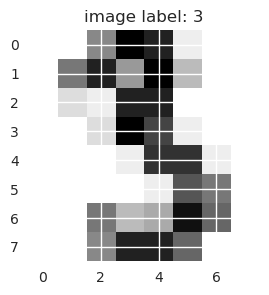

In [11]:
sample_index = 3  # change this to see different examples
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("image label: %d" % digits.target[sample_index])

## 4. Data preprocessing

In [12]:
np.unique(digits.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
data = np.asarray(digits.data, dtype="float32")
target = np.asarray(digits.target, dtype="int32")

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37
)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

One of the transformed sample (after feature standardization):

Text(0.5, 1.0, 'transformed sample\n(standardised)')

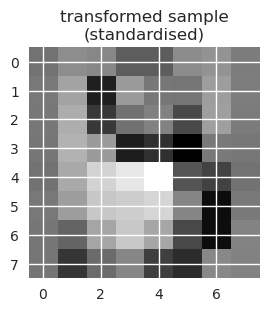

In [14]:
sample_index = 1
plt.figure(figsize=(3, 3))
plt.imshow(
    X_train[sample_index].reshape(8, 8), cmap=plt.cm.gray_r, interpolation="nearest"
)
plt.title("transformed sample\n(standardised)")

The scaler objects makes it possible to recover the original sample:

Text(0.5, 1.0, 'original sample')

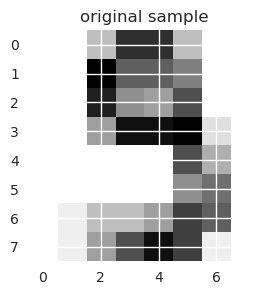

In [15]:
plt.figure(figsize=(3, 3))
plt.imshow(
    scaler.inverse_transform(X_train[sample_index].reshape(1, -1)).reshape(8, 8),
    cmap=plt.cm.gray_r,
    interpolation="nearest",
)
plt.title("original sample")

## 5. Softmax

Softmax Formula Implementation:
$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [16]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

Test the softmax function by applying it on an example vector. Check that the components sum to one.

In [17]:
print(softmax([10, 2, -3]))
print(sum(softmax([10, 2, -3])))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]
1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call (but we need that):

In [18]:
X = np.array([[10, 2, -3], [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


## 6. Negative log likelihood

Given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, will return the negative log likelihood.

In [19]:
EPSILON = 1e-8


def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [0.99, 0.01, 0]))

0.01005032575249135


Check that the `nll` of a very confident yet incorrect prediction is a much higher positive number:

In [20]:
print(nll([1, 0, 0], [0.01, 0.01, 0.98]))

4.605169185988591


Check that the average NLL of the following 3 almost perfect predictions is close to 0

In [21]:
Y_true = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
Y_pred = np.array([[0, 1, 0], [0.99, 0.01, 0], [0, 0, 1]])

print(nll(Y_true, Y_pred))

0.0033501019174971905


## 7. Logistic Regression Model with Gradient Decent

These are the functions that you need for implementing gradient descent. It is very similar to the gradient descent that you implemented yesterday. The difference is that here we have now multiple predictors (for every digit one - so in total 10). That means that $Y$ is now a n x 10 matrix.

Also the definition of the weights is a bit different. We use here $W$ (matrix) for the weights and $\mathbf b$ (vector) for the biases/intercepts, but in principle also here they could be combined to one common coefficient matrix.

In [22]:
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

W = np.random.uniform(size=(n_features, n_classes), high=0.1, low=-0.1)
b = np.random.uniform(size=n_classes, high=0.1, low=-0.1)
output_size = n_classes


def predict_proba(X, W, b):
    # Compute normalised scores
    Z = np.dot(X, W) + b
    return softmax(Z)


def predict(X, W, b):
    # For each sample return the predicted class
    if len(X.shape) == 1:
        return np.argmax(predict_proba(X, W, b))
    else:
        return np.argmax(predict_proba(X, W, b), axis=1)


def grad_loss(X, Y_true, W, b):
    # Compute gradient with respect to W and b for a sample x and the true labels Y_true
    y_pred = predict_proba(X, W, b)
    dnll_output = y_pred - Y_true
    grad_W = np.outer(x, dnll_output)
    grad_b = dnll_output
    grads = {"W": grad_W, "b": grad_b}
    return grads


def train(X, Y_true, W, b, learning_rate):
    # Traditional gradient descent update without momentum
    grads = grad_loss(X, Y_true, W, b)
    W = W - learning_rate * grads["W"]
    b = b - learning_rate * grads["b"]
    return W, b


def loss(X, Y_true, W, b):
    # Use `nll` to compute the loss for the sample x with true label y
    return nll(Y_true, predict_proba(X, W, b))


def accuracy(X, Y_true, W, b):
    # Compute accuracy for samples X with true labels y
    y_preds = np.argmax(predict_proba(X, W, b), axis=1)
    return np.mean(y_preds == np.argmax(Y_true, axis=1))

## 8. Build and evaluate untrained model to test its inference

In [23]:
print("Evaluation of the untrained model:")
train_loss = loss(X_train, Y_train, W, b)
train_acc = accuracy(X_train, Y_train, W, b)
test_acc = accuracy(X_train, Y_train, W, b)

print(
    "train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
    % (train_loss, train_acc, test_acc)
)

Evaluation of the untrained model:
train loss: 2.2299, train acc: 0.157, test acc: 0.157


Test model on first example

4


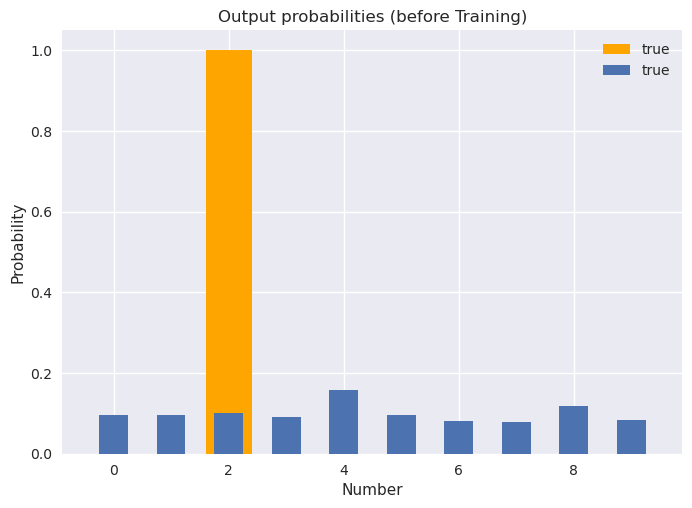

In [24]:
sample_idx = 10
plt.bar(
    np.arange(len(Y_train[sample_idx])),
    Y_train[sample_idx],
    linestyle="--",
    label="true",
    color="orange",
)
plt.bar(
    np.arange(len(Y_train[sample_idx])),
    predict_proba(X_train[sample_idx], W, b),
    linestyle="--",
    label="true",
    width=0.5,
)
plt.title("Output probabilities (before Training)")
plt.xlabel("Number")
plt.ylabel("Probability")
plt.legend()
print(np.argmax(predict_proba(X_train[sample_idx], W, b)))
None

## 9. Train for one epoch 

In [25]:
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, Y_train)):
    W, b = train(x, y, W, b, learning_rate)
    if i % 100 == 0:
        train_loss = loss(X_train, Y_train, W, b)
        train_acc = accuracy(X_train, Y_train, W, b)
        test_acc = accuracy(X_test, Y_test, W, b)
        print(
            "Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
            % (i, train_loss, train_acc, test_acc)
        )

Update #0, train loss: 2.2061, train acc: 0.181, test acc: 0.174
Update #100, train loss: 1.2212, train acc: 0.753, test acc: 0.767
Update #200, train loss: 0.8181, train acc: 0.863, test acc: 0.889
Update #300, train loss: 0.6132, train acc: 0.907, test acc: 0.919
Update #400, train loss: 0.5197, train acc: 0.910, test acc: 0.926
Update #500, train loss: 0.4515, train acc: 0.918, test acc: 0.926
Update #600, train loss: 0.3940, train acc: 0.929, test acc: 0.937
Update #700, train loss: 0.3599, train acc: 0.936, test acc: 0.963
Update #800, train loss: 0.3396, train acc: 0.940, test acc: 0.959
Update #900, train loss: 0.3148, train acc: 0.938, test acc: 0.956
Update #1000, train loss: 0.2959, train acc: 0.945, test acc: 0.963
Update #1100, train loss: 0.2778, train acc: 0.946, test acc: 0.963
Update #1200, train loss: 0.2663, train acc: 0.948, test acc: 0.963
Update #1300, train loss: 0.2542, train acc: 0.952, test acc: 0.956
Update #1400, train loss: 0.2434, train acc: 0.955, test acc

2


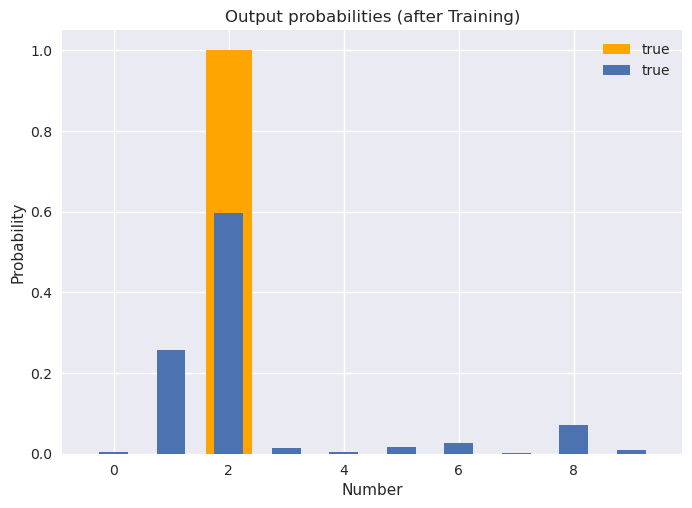

In [26]:
sample_idx = 10
plt.bar(
    np.arange(len(Y_train[sample_idx])),
    Y_train[sample_idx],
    linestyle="--",
    label="true",
    color="orange",
)
plt.bar(
    np.arange(len(Y_train[sample_idx])),
    predict_proba(X_train[sample_idx], W, b),
    linestyle="--",
    label="true",
    width=0.5,
)
plt.title("Output probabilities (after Training)")
plt.xlabel("Number")
plt.ylabel("Probability")
plt.legend()
print(np.argmax(predict_proba(X_train[sample_idx], W, b)))
None

## Bonus: Confusion Matrix

In [27]:
cm = confusion_matrix(y_test, predict(X_test, W, b))
cmdf = pd.DataFrame(cm)

In [28]:
cmdf

,0,1,2,3,4,5,6,7,8,9
0,27,0,0,0,0,0,0,0,0,0
1,0,26,0,0,0,0,0,0,0,3
2,0,0,29,0,0,0,0,0,0,0
3,0,0,0,17,0,0,0,0,0,0
4,0,0,0,0,26,0,0,1,1,0
5,0,0,0,0,0,30,0,0,0,1
6,0,0,0,0,0,0,26,0,0,0
7,0,0,0,0,0,0,0,24,0,0
8,0,2,0,0,0,1,0,1,30,1
9,0,0,0,0,0,0,0,0,1,23


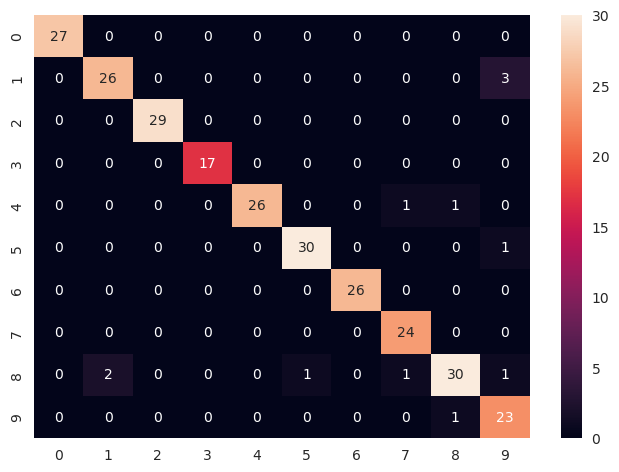

In [29]:
import seaborn as sns

# plot the confusion matrix as heatmap
sns.heatmap(cmdf, annot=True)
None

--------------
# End of This Notebook